In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# %cd labs-cv-colab/03-DL-basics

In [2]:
# setup for images
from IPython.display import Image

# Lab 04 Overfitting and underfitting



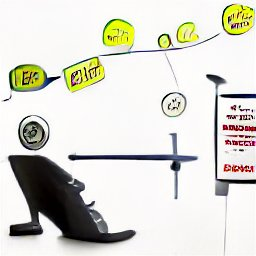

In [3]:
Image("img/craiyon-overfitting.jpg")
# Craiyon.com "Overfitting" 

## 1 Objectives

Keras will keep a history of the training and validation loss over the epochs that it is training the model. 

In this notebook, we're going to learn:

- how to interpret these learning curves
- how we can use them to guide model development
- use learning curves for evidence of *underfitting* and *overfitting* 
- strategies for correcting model underfitting and overfitting



## 2 Interpreting the Learning Curves #

You might think about the information in the training data as being of two kinds: *signal* and *noise*. The signal is the part that generalizes, the part that can help our model make predictions from new data. The noise is that part that is *only* true of the training data; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the *validation* data. (You could see our lesson on [model validation](https://www.kaggle.com/dansbecker/model-validation) in *Introduction to Machine Learning* for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the **learning curves**. To train deep learning models effectively, we need to be able to interpret them.   


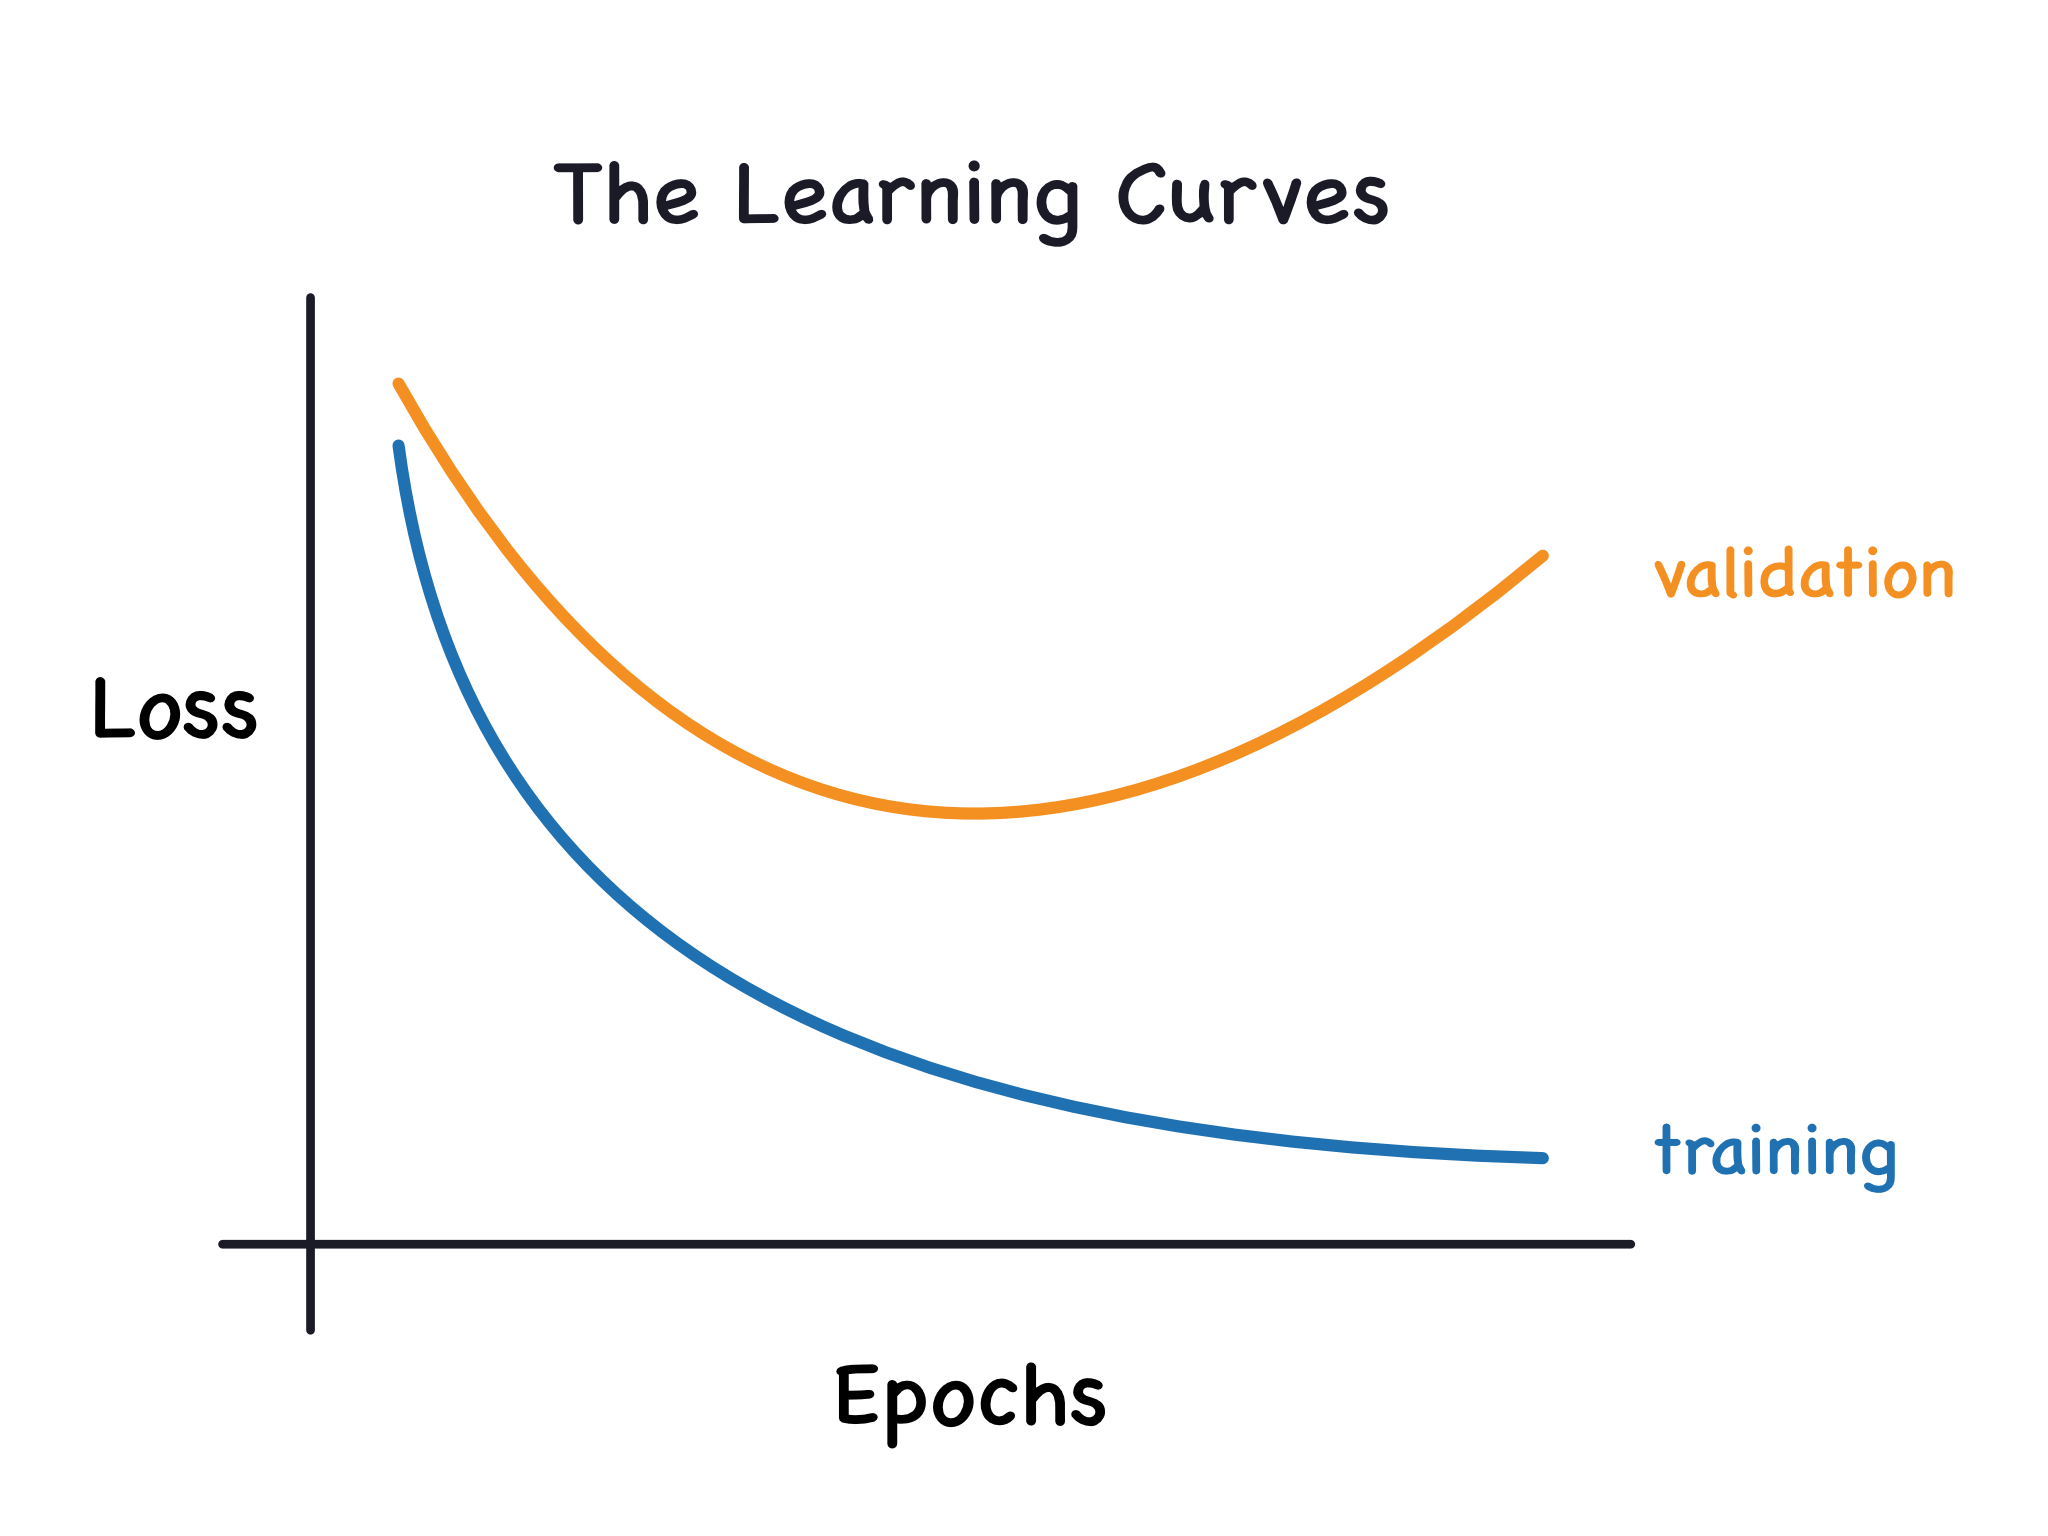

In [6]:
Image("img/4-1.png", width = 600)
# A graph of training and validation loss

<br>

Now, the training loss will go down either when the model learns signal or when it learns noise. But the validation loss will go down only when the model learns signal. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, but when it learns noise a *gap* is created in the curves. The size of the gap tells you how much noise the model has learned.

Ideally, we would create models that learn all of the signal and none of the noise. This will practically never happen. Instead we make a trade. We can get the model to learn more signal at the cost of learning more noise. So long as the trade is in our favor, the validation loss will continue to decrease. After a certain point, however, the trade can turn against us, the cost exceeds the benefit, and the validation loss begins to rise.



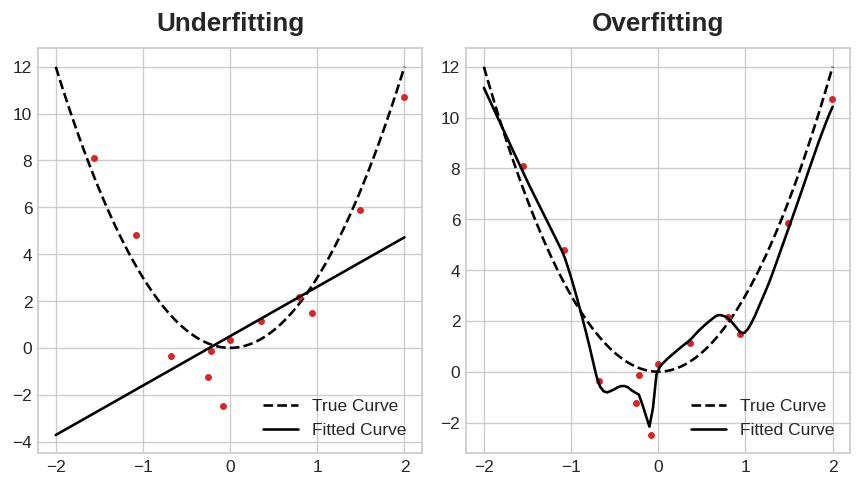

In [7]:
Image("img/4-2.png", width = 600)
# Underfitting and overfitting

<br>

This trade-off indicates that there can be two problems that occur when training a model: not enough signal or too much noise. **Underfitting** the training set is when the loss is not as low as it could be because the model hasn't learned enough *signal*. **Overfitting** the training set is when the loss is not as low as it could be because the model learned too much *noise*. The trick to training deep learning models is finding the best balance between the two.

We'll look at a couple ways of getting more signal out of the training data while reducing the amount of noise.



## 3 Capacity

A model's **capacity** refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity.

You can increase the capacity of a network either by making it *wider* (more units to existing layers) or by making it *deeper* (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones. Which is better just depends on the dataset.

```
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

wider = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

deeper = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])
```

You'll explore how the capacity of a network can affect its performance in the exercise.



## 4 Early Stopping

We mentioned that when a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, we can simply stop the training whenever it seems the validation loss isn't decreasing anymore. Interrupting the training this way is called **early stopping**.

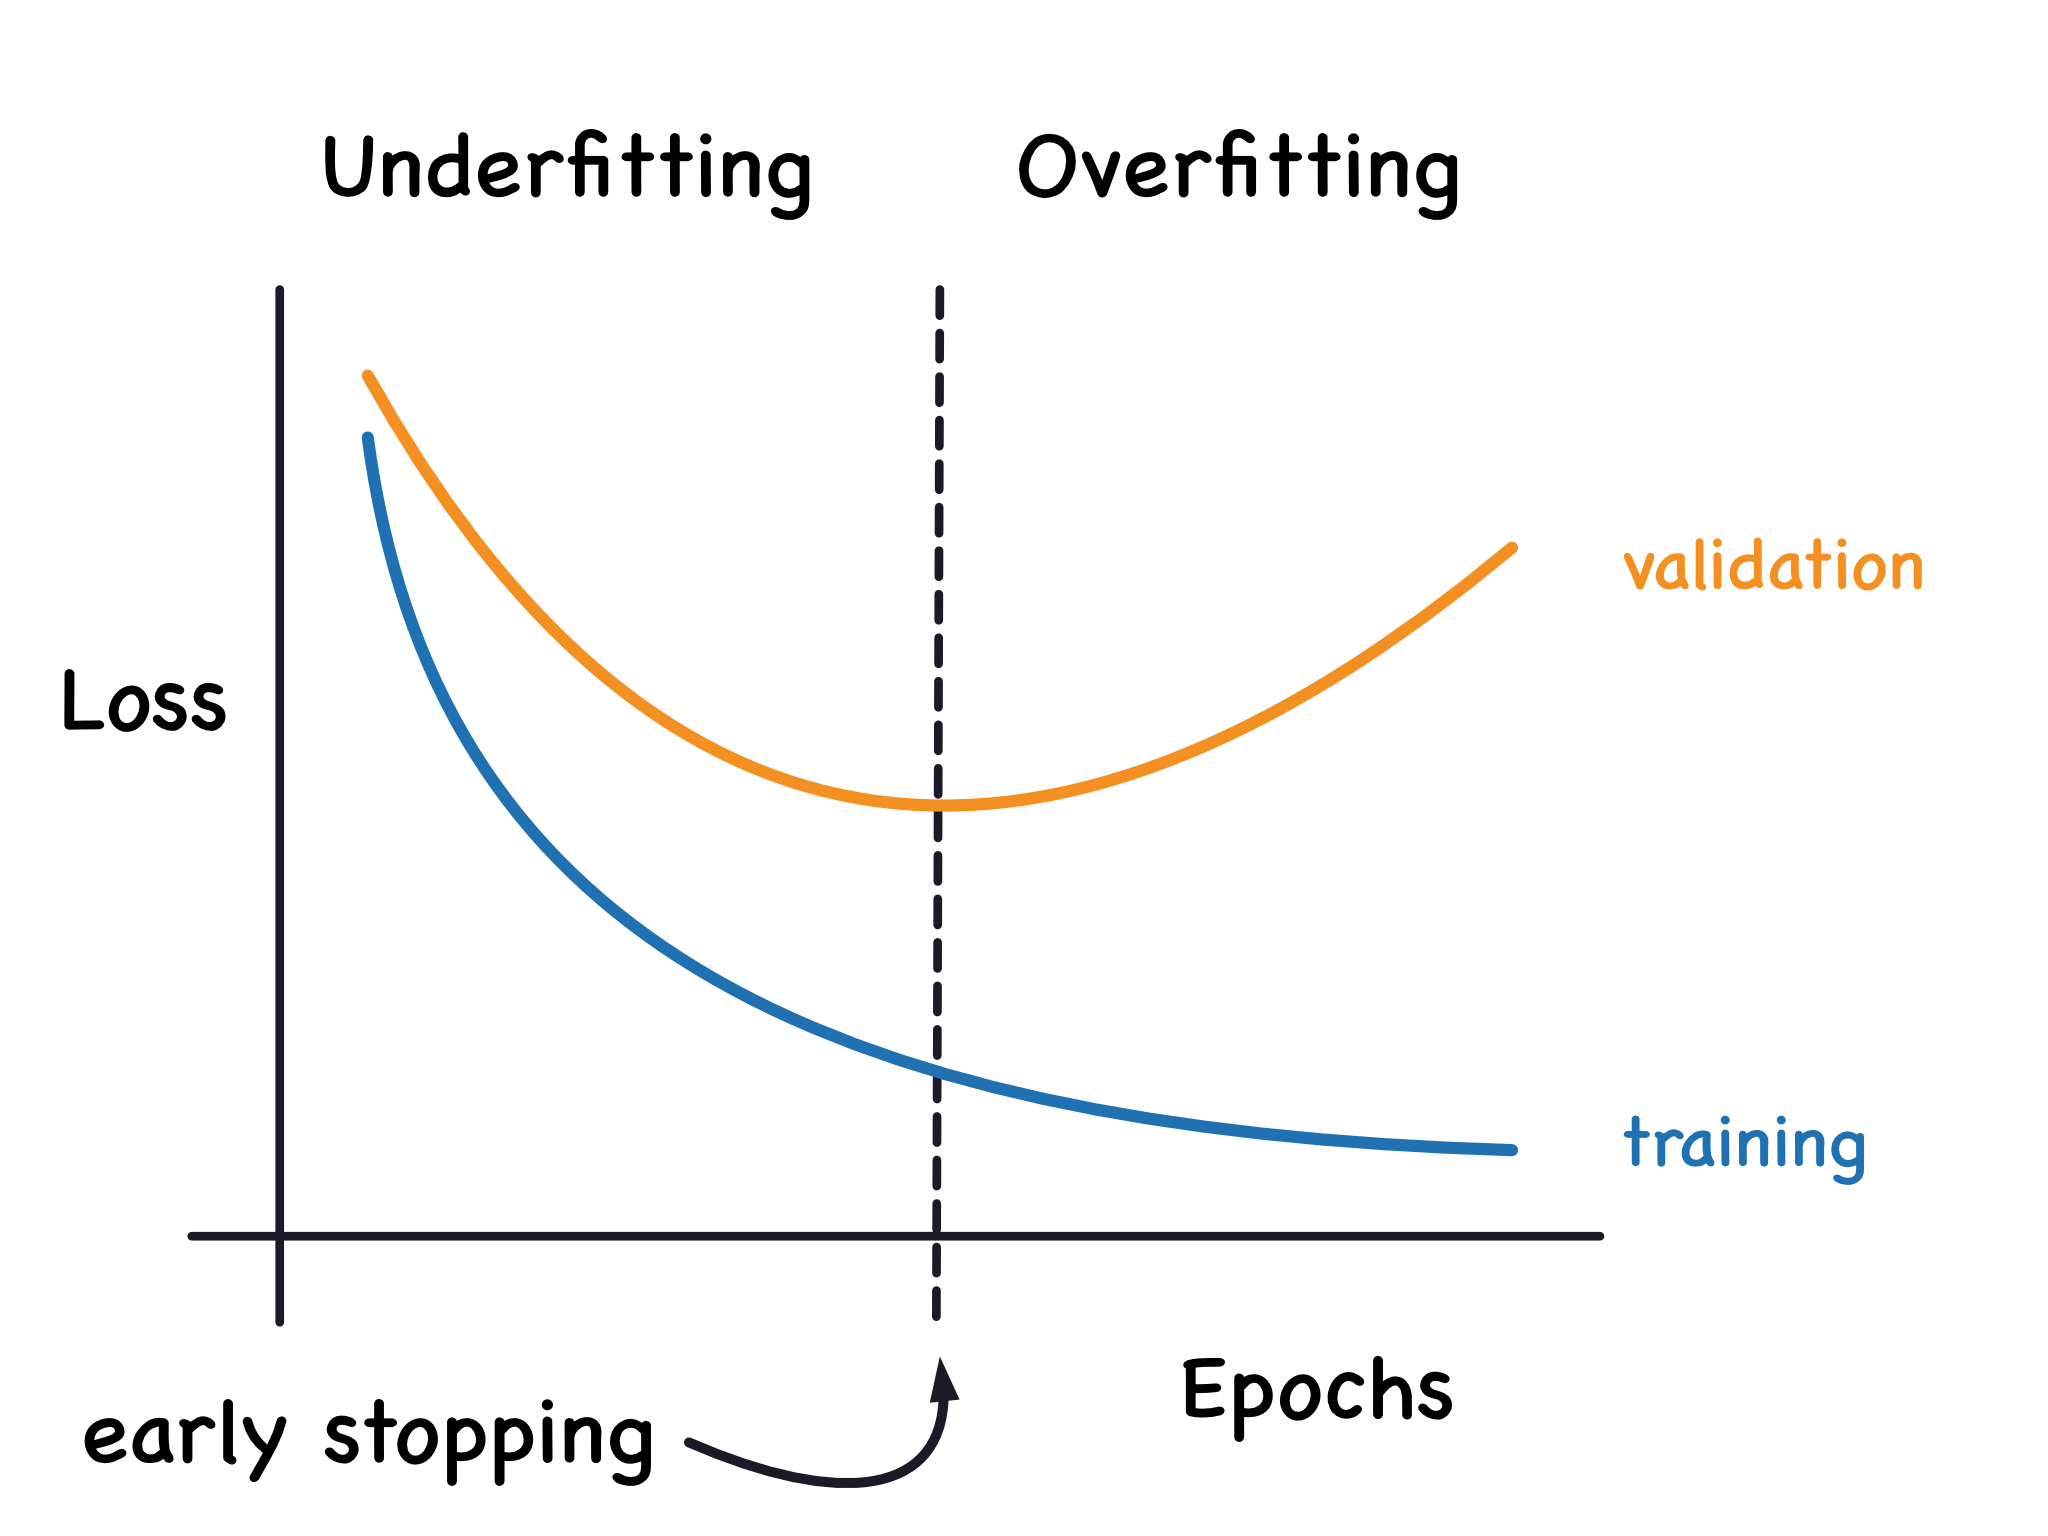

In [8]:
Image("img/4-3.png", width = 600)
# A graph of the learning curves with early stopping at the minimum validation loss, 
# underfitting to the left of it and overfitting to the right

Once we detect that the validation loss is starting to rise again, we can reset the weights back to where the minimum occured. This ensures that the model won't continue to learn noise and overfit the data.

Training with early stopping also means we're in less danger of stopping the training too early, before the network has finished learning signal. So besides preventing overfitting from training too long, early stopping can also prevent *underfitting* from not training long enough. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.



## 5 Adding Early Stopping 

In Keras, we include early stopping in our training through a callback. A **callback** is just a function you want run every so often while the network trains. The early stopping callback will run after every epoch. (Keras has [a variety of useful callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) pre-defined, but you can [define your own](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback), too.)

In [1]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

<br>

These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 20 epochs, then stop the training and keep the best model you found." It can sometimes be hard to tell if the validation loss is rising due to overfitting or just due to random batch variation. The parameters allow us to set some allowances around when to stop.

As we'll see in our example, we'll pass this callback to the `fit` method along with the loss and optimizer.



## 6 Example - Train a Model with Early Stopping

Let's continue developing the model from the example in the last tutorial. We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

Here's the data prep again.

In [1]:

import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('data/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


<br>

Now let's increase the capacity of the network. We'll go for a fairly large network, but rely on the callback to halt the training once the validation loss shows signs of increasing.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

<br>

After defining the callback, add it as an argument in `fit` (you can have several, so put it in a list). Choose a large number of epochs when using early stopping, more than you'll need.

In [1]:
# nb needs colab

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

NameError: name 'model' is not defined

## 7 Exercises

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [3]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


<br>

Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1941


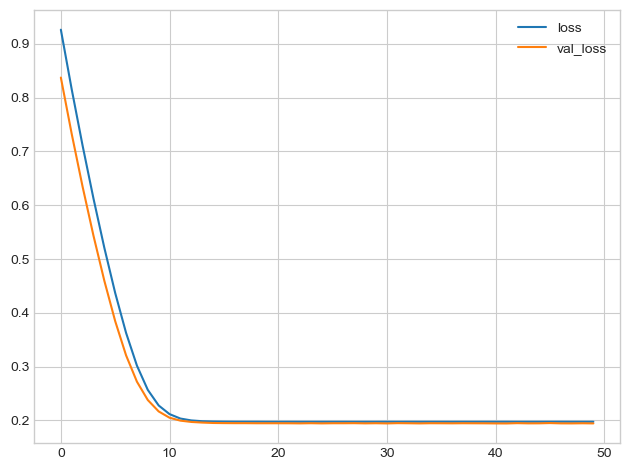

In [5]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

<br>

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

In [ ]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 7.1 Evaluate Baseline

What do you think? Would you say intuitively this model is underfitting, overfitting, just right?

<br>

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.2415 - val_loss: 0.2018
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2019 - val_loss: 0.1970
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1973 - val_loss: 0.1956
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1940 - val_loss: 0.1939
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1925 - val_loss: 0.1936
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1905 - val_loss: 0.1951
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1890 - val_loss: 0.1925
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1879 - val_loss: 0.1932
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1869 - val_loss: 0.1926
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1859 - val_loss: 0.1930
Epoch 11/50
49/49 [

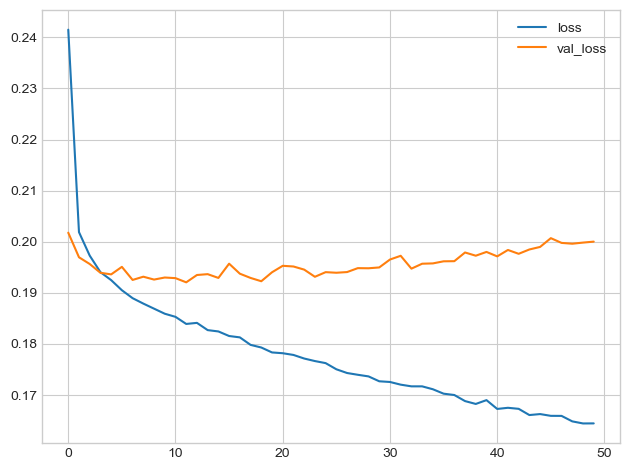

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 7.2 Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

### 7.3 Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [ ]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
# early_stopping = ____


Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 7.4 Train and Interpret

Was this an improvement compared to training without early stopping?